In [24]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc

def check_read_inside_region(start, seq, region):
        read_end = start + len(seq)
        region_start = int(region.split(":")[1].split("-")[0])
        region_end = int(region.split(":")[1].split("-")[1])
        if start >= region_start and read_end <= region_end:
            return "in"
        else: 
            return "overlap"

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/HNSD_mini/outdir"
path_to_read_data = "/media/hieunguyen/GSHD_HN01/raw_data/reads_from_450_regions_with_readname_TMDfull"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

mode = "all"

metadata = pd.read_excel("metadata_cfDNA_lowpdepth_TMD_bam_cov.xlsx")

path_to_main_output = os.path.join(outdir, PROJECT, output_version)
path_to_01_output = os.path.join(path_to_main_output, "PANCANCER01_output")
path_to_02_output = os.path.join(path_to_main_output, "PANCANCER02_output")
os.system(f"mkdir -p {path_to_02_output}")

all_files = [item for item in pathlib.Path(path_to_01_output).glob("*.candi_reads.csv")]
all_read_files = [item for item in pathlib.Path(path_to_01_output).glob("*.read_classification.csv")]

##### read countdf: raw count and in-read count number. 
if os.path.isfile(os.path.join(path_to_01_output, "all_count.csv")) == False:
    all_samples = []
    raw_counts = []
    in_read_counts = []

    for file in tqdm(all_read_files):
        tmpdf = pd.read_csv(file)
        raw_count = tmpdf.shape[0]
        in_read_count = tmpdf[tmpdf["read_overlap_rate"] == "in"].shape[0]
        all_samples.append(file.name.replace(".read_classification.csv", ""))
        raw_counts.append(raw_count)
        in_read_counts.append(in_read_count)

    countdf = pd.DataFrame({"SampleID": all_samples, "raw_count": raw_counts, "in_read_count": in_read_counts})
    countdf.to_csv(os.path.join(path_to_01_output, "all_count.csv"))
else:
    print(f"Countdf existst, reading in from {os.path.join(path_to_01_output, 'all_count.csv')} ...")
    countdf = pd.read_csv(os.path.join(path_to_01_output, "all_count.csv"))

all_samples = []
all_mean_candi_reads = []
for file in all_files:
    tmpdf = pd.read_csv(file)
    mean_candi_reads = tmpdf.candi_reads.mean()
    all_samples.append(file.name.split(".")[0])
    all_mean_candi_reads.append(mean_candi_reads)

candidf = pd.DataFrame({"SampleID": all_samples, "num_candi_reads": all_mean_candi_reads})
candidf = candidf.merge(countdf, right_on = "SampleID", left_on = "SampleID")
candidf["ratio_raw"] = candidf["num_candi_reads"] / candidf["raw_count"]
candidf["ratio_in_reads"] = candidf["num_candi_reads"] / candidf["in_read_count"]
candidf = candidf.merge(metadata[["SampleID", "Label", "Set"]], right_on = "SampleID", left_on = "SampleID")
candidf = candidf.fillna(0)

#####-------------------------------------------------------------#####
##### summary model metrics on training set.
#####-------------------------------------------------------------#####
candidf["detail_label"] = candidf["Label"]
candidf["Label"] = candidf["Label"].apply(lambda x: "Cancer" if x != "Control" else "Control")

candidf_train = candidf[candidf["Set"] == "train"].copy()
candidf_test = candidf[candidf["Set"] != "train"].copy()

Countdf existst, reading in from /media/hieunguyen/HNSD_mini/outdir/TMD450_TCGA_data_analysis/20240910/PANCANCER01_output/all_count.csv ...


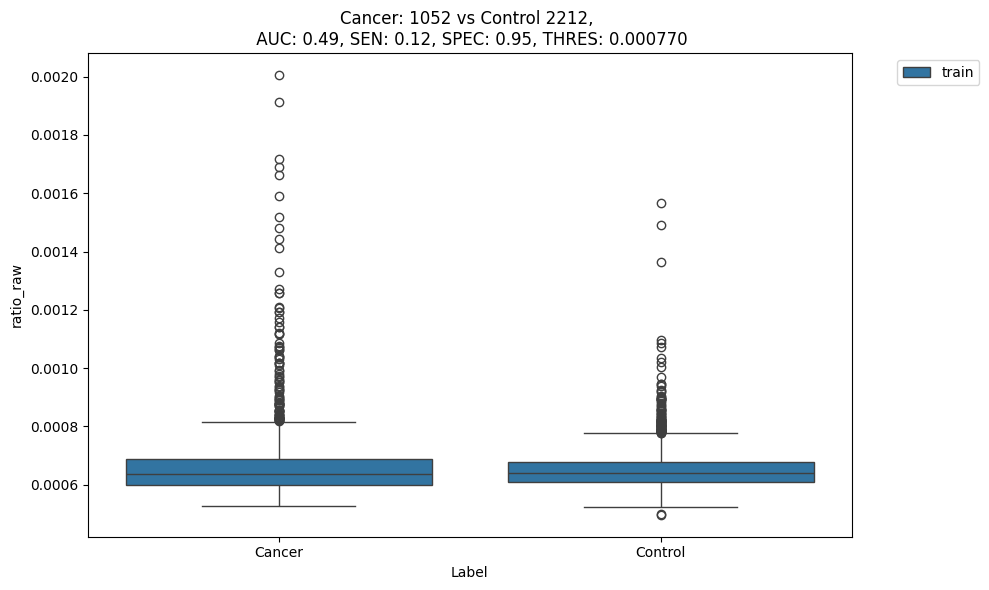

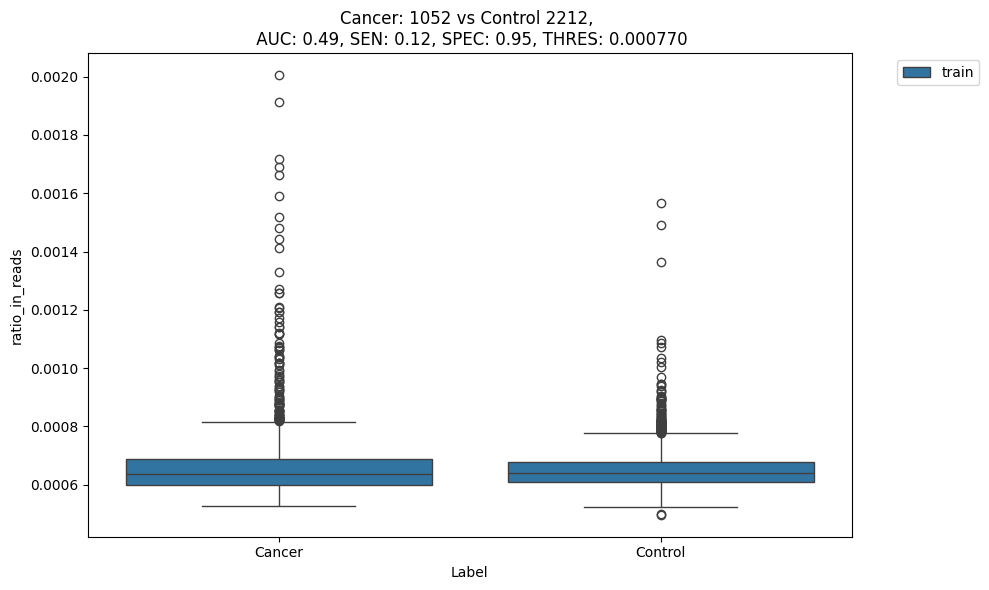

0.0007704120774295148
0.0007704120774295148


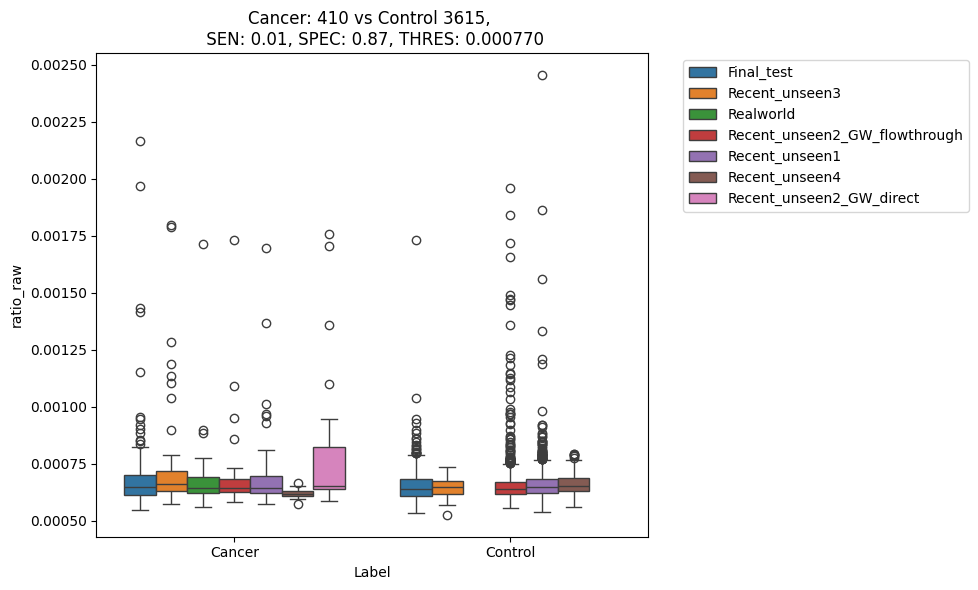

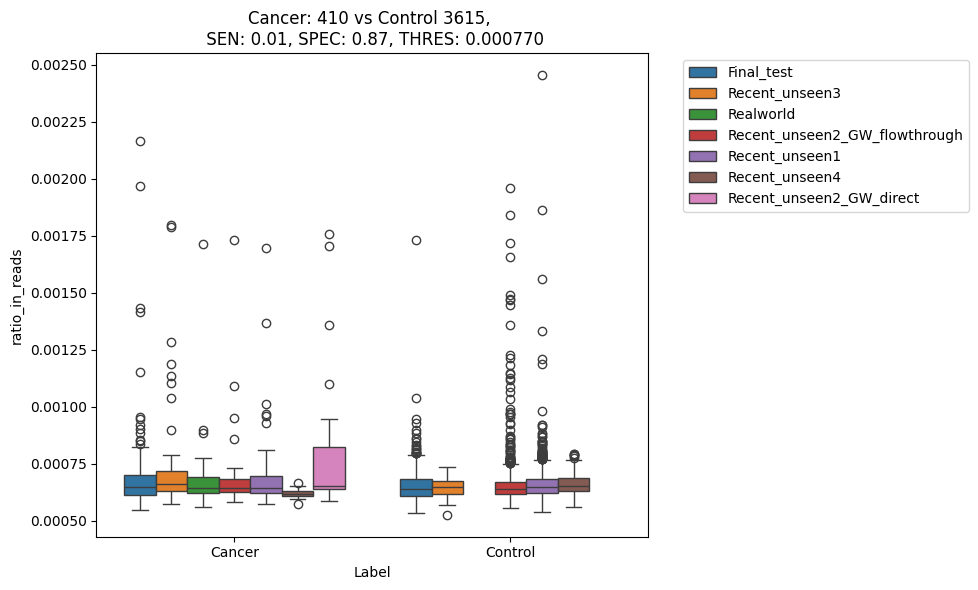

(0.0007704120774295148, 0.0007704120774295148)

In [ ]:
def plot_roc_curve(inputdf, figname1, figname2, selected_thres_ratio_raw = None, selected_thres_ratio_in_reads = None):
    input_cancer_class = "Cancer"
    fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(inputdf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), inputdf['ratio_raw'])
    num_cancer = inputdf[inputdf["Label"] == input_cancer_class].shape[0]
    num_control = inputdf[inputdf["Label"] != input_cancer_class].shape[0]

    if (selected_thres_ratio_raw is None) or (selected_thres_ratio_in_reads is None):
        aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
        aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

        selected_thres_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
        selected_spec_ratio_raw = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
        selected_sens_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

        # Calculate the AUC
        roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
        title_raw = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_raw:.2f}, SPEC: {selected_spec_ratio_raw:.2f}, THRES: {selected_thres_ratio_raw:.6f}"

        # Calculate the ROC curve for the values ratio_in_reads
        fpr_ratio_in_reads, tpr_ratio_in_reads, thres_ratio_in_reads = roc_curve(inputdf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), inputdf['ratio_in_reads'])
        aucdf = pd.DataFrame({"fpr": fpr_ratio_in_reads, "tpr": tpr_ratio_in_reads, "thres": thres_ratio_in_reads})
        aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

        selected_thres_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
        selected_spec_ratio_in_reads = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
        selected_sens_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

        # Calculate the AUC
        roc_auc = auc(fpr_ratio_in_reads, tpr_ratio_in_reads)
        title_in_reads = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_in_reads:.2f}, SPEC: {selected_spec_ratio_in_reads:.2f}, THRES: {selected_thres_ratio_in_reads:.6f}"
        
    else:
        inputdf["prediction_raw"] = inputdf["ratio_raw"].apply(lambda x: 1 if x >= selected_thres_ratio_raw else 0)
        inputdf["prediction_in_reads"] = inputdf["ratio_in_reads"].apply(lambda x: 1 if x >= selected_thres_ratio_in_reads else 0)
        
        SEN_raw = inputdf[(inputdf["prediction_raw"] == 1) & (inputdf["Label"] == input_cancer_class)].shape[0]/inputdf.shape[0]
        SPEC_raw = inputdf[(inputdf["prediction_raw"] == 0) & (inputdf["Label"] != input_cancer_class)].shape[0]/inputdf.shape[0]

        SEN_in_reads = inputdf[(inputdf["prediction_in_reads"] == 1) & (inputdf["Label"] == input_cancer_class)].shape[0]/inputdf.shape[0]
        SPEC_in_reads = inputdf[(inputdf["prediction_in_reads"] == 0) & (inputdf["Label"] != input_cancer_class)].shape[0]/inputdf.shape[0]

        title_raw = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n SEN: {SEN_raw:.2f}, SPEC: {SPEC_raw:.2f}, THRES: {selected_thres_ratio_raw:.6f}"
        title_in_reads = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n SEN: {SEN_in_reads:.2f}, SPEC: {SPEC_in_reads:.2f}, THRES: {selected_thres_ratio_in_reads:.6f}"

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=inputdf, x="Label", y="ratio_raw", hue="Set")
    plt.title(title_raw)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_02_output, figname1), format='svg')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=inputdf, x="Label", y="ratio_in_reads", hue="Set")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title_in_reads)
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_02_output, figname2), format='svg')
    plt.show()
    
    return selected_thres_ratio_raw, selected_thres_ratio_in_reads
    
selected_thres_ratio_raw, selected_thres_ratio_in_reads = plot_roc_curve(candidf_train, 
                                                                         "boxplot_ratio_candi_to_raw_counts.train.svg", 
                                                                         "boxplot_ratio_candi_to_inside_read_counts.train.svg")
print(selected_thres_ratio_raw)
print(selected_thres_ratio_in_reads)
plot_roc_curve(candidf_test, "boxplot_ratio_candi_to_raw_counts.test.svg", 
               "boxplot_ratio_candi_to_inside_read_counts.test.svg", 
               selected_thres_ratio_raw, 
               selected_thres_ratio_in_reads)
